In [2]:
from nilearn.image import resample_to_img, smooth_img
from nilearn.plotting import plot_stat_map
import numpy as np
import nibabel as nb
import pylab as plt
from scipy.ndimage.filters import maximum_filter
from skimage.feature import peak_local_max
%matplotlib inline

In [3]:
import pyneurovault

In [4]:
from pyneurovault import api

# Get a collection
collection = api.get_collections(pks=1804)

SyntaxError: invalid syntax (api.py, line 45)

In [ ]:
plt.imshow(new_nii.get_data()[:,:,80])

In [ ]:
slice = new_nii.get_data()[:,:,80]
slice[slice < 3] = 0
plt.imshow(slice)



In [9]:
from glob import glob
import os
maps = glob("D:/data/hcp_statmaps/*.nii.gz")
vetted = [v.split("_")[-1][:-4] for v in glob("D:/drive/workspace/atlas_analysis/vetted_thumbnails/*")]
maps = [map for map in maps if os.path.split(map)[-1][:-7] in vetted]
maps

[]

In [ ]:
os.path.split(map)[-1][:-7]
import png
from scipy.misc import imsave, imread
from scipy.signal import resample

In [5]:
imread("D:/data/pix2pix-hcp/train/B/100307_EMOTION.png")[:,20]

NameError: name 'imread' is not defined

In [6]:
(((slice[:,20]+10)/20)*np.iinfo(np.uint16).max).astype(np.uint16)

TypeError: 'type' object is not subscriptable

In [7]:

import numpy as np
import tensorflow as tf
def np_to_tfrecords(X, Y, file_path_prefix, verbose=True):
    """
    Converts a Numpy array (or two Numpy arrays) into a tfrecord file.
    For supervised learning, feed training inputs to X and training labels to Y.
    For unsupervised learning, only feed training inputs to X, and feed None to Y.
    The length of the first dimensions of X and Y should be the number of samples.
    
    Parameters
    ----------
    X : numpy.ndarray of rank 2
        Numpy array for training inputs. Its dtype should be float32, float64, or int64.
        If X has a higher rank, it should be rshape before fed to this function.
    Y : numpy.ndarray of rank 2 or None
        Numpy array for training labels. Its dtype should be float32, float64, or int64.
        None if there is no label array.
    file_path_prefix : str
        The path and name of the resulting tfrecord file to be generated, without '.tfrecords'
    verbose : bool
        If true, progress is reported.
    
    Raises
    ------
    ValueError
        If input type is not float (64 or 32) or int.
    
    """
    def _dtype_feature(ndarray):
        """match appropriate tf.train.Feature class with dtype of ndarray. """
        assert isinstance(ndarray, np.ndarray)
        dtype_ = ndarray.dtype
        if dtype_ == np.float64 or dtype_ == np.float32:
            return lambda array: tf.train.Feature(float_list=tf.train.FloatList(value=array))
        elif dtype_ == np.int64:
            return lambda array: tf.train.Feature(int64_list=tf.train.Int64List(value=array))
        else:  
            raise ValueError("The input should be numpy ndarray. \
                               Instaed got {}".format(ndarray.dtype))
            
    assert isinstance(X, np.ndarray)
    assert len(X.shape) == 2  # If X has a higher rank, 
                               # it should be rshape before fed to this function.
    assert isinstance(Y, np.ndarray) or Y is None
    
    # load appropriate tf.train.Feature class depending on dtype
    dtype_feature_x = _dtype_feature(X)
    if Y is not None:
        assert X.shape[0] == Y.shape[0]
        assert len(Y.shape) == 2
        dtype_feature_y = _dtype_feature(Y)            
    
    # Generate tfrecord writer
    result_tf_file = file_path_prefix + '.tfrecords'
    writer = tf.python_io.TFRecordWriter(result_tf_file)
    if verbose:
        print("Serializing {:d} examples into {}".format(X.shape[0], result_tf_file))
        
    # iterate over each sample,
    # and serialize it as ProtoBuf.
    for idx in range(X.shape[0]):
        x = X[idx]
        if Y is not None:
            y = Y[idx]
        
        d_feature = {}
        d_feature['X'] = dtype_feature_x(x)
        if Y is not None:
            d_feature['Y'] = dtype_feature_y(y)
            
        features = tf.train.Features(feature=d_feature)
        example = tf.train.Example(features=features)
        serialized = example.SerializeToString()
        writer.write(serialized)
    
    if verbose:
        print("Writing {} done!".format(result_tf_file))

In [10]:
maps = glob("D:/data/hcp_statmaps/*.nii.gz")


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

for map in maps:
    #if '183034_EMOTION' not in map:
    #    continue
    old_nii = nb.load(map)
    new_nii = smooth_img(old_nii, 6)
    slice = new_nii.get_data()[:,:,40]
    zeros = new_nii.get_data()[:,:,40] == 0
    #slice_mask = imresize(slice == 0, (512,512), interp="nearest")
    #slice = imresize(slice, (512,512), interp="nearest")
    #slice[slice_mask == 255] = 0
    #slice = np.lib.pad(slice, [(slice.shape[1]-slice.shape[0]+292,0), (292,0)], 'constant', constant_values=(0, 0))
    #plt.figure(figsize=(12,9))
    #plt.subplot(2,2,1)
    #zeros = np.logical_or(slice == slice[0,0], np.isnan(slice))

    #slice = (slice - slice.min())/(slice.max()-slice.min())
    #slice[zeros] = 0
    slice[slice < 0] = (slice[slice < 0]/(-slice[slice < 0].min()))*0.5
    slice[slice > 0] = (slice[slice > 0]/slice[slice > 0].max())*0.5
    slice = (((slice+0.5)/1.0)*np.iinfo(np.uint16).max).astype(np.uint16)
    peaks = peak_local_max(slice, indices=False, min_distance=5, threshold_rel=0.85)
    if peaks.sum():
        #print(slice[:,20])
        #plt.imshow(slice)
        #plt.colorbar()
        #imsave("D:/data/pix2pix-hcp/train/B/" + os.path.split(map)[-1][:-7] + ".png", slice)
        #plt.subplot(2,2,2)
        #plt.imshow(peaks)
        #imsave("D:/data/pix2pix-hcp/train/A/" + os.path.split(map)[-1][:-7] + ".png", peaks)
        
        # Create a feature
        writer = tf.python_io.TFRecordWriter("D:/data/pix2pix-hcp/train/combined_tf/" + os.path.split(map)[-1][:-7] +".tfrecords")
        example = tf.train.Example(features=tf.train.Features(feature={
                                                            'height': _int64_feature(slice.shape[1]),
                                                            'width': _int64_feature(slice.shape[0]),
                                                            'imageA_raw': _bytes_feature(peaks.astype(np.int16).tostring()),
                                                            'imageB_raw': _bytes_feature(slice.astype(np.int16).tostring())}))

        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
        writer.close()

In [15]:
peaks.astype(np.int16)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

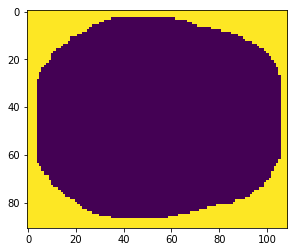

In [198]:
plt.imshow(zeros)

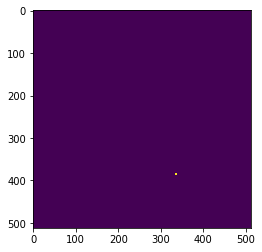

In [182]:
plt.imshow(slice_mask)

In [155]:
resample_to_img?

In [125]:
png.from_array?

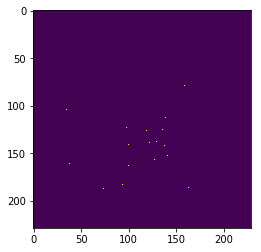

In [87]:
plt.imshow(peaks)

In [148]:
slice.shape

(229, 229)

In [149]:
512-219

293

In [153]:
slice.shape

(522, 522)

In [159]:
from scipy.misc import imresize

In [168]:
s = imresize(slice, (512,512), interp="nearest")

In [169]:
s

array([[149, 149, 149, ..., 149, 149, 149],
       [149, 149, 149, ..., 149, 149, 149],
       [149, 149, 149, ..., 149, 149, 149],
       ..., 
       [149, 149, 149, ..., 149, 149, 149],
       [149, 149, 149, ..., 149, 149, 149],
       [149, 149, 149, ..., 149, 149, 149]], dtype=uint8)